# Data 620 - Project 3
Baron Curtin, Heather Geiger, Mikhail Groysman, Betsy Rosalen 

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python,
and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender
classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are
satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what
you'd expect? 

In [6]:
# library imports
import random
from collections import Counter
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from nltk import NaiveBayesClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Data Loading/Preparation
In the following cells, we will be loading the corpus into memory, labelling all of the names, and then randomizing the
list of names for later use. Randomizing the names will ensure that our training/test sets will contain both genders from 
which we should be able to create numerous features from.

In [7]:
# read in names from the files
# label each name with corresponding gender
# names to be lowercase for easy recognition 
download('names')
males = [(name.lower(), 'male') for name in names.words('male.txt')]
females = [(name.lower(), 'female') for name in names.words('female.txt')]

# combine lists of names
all_names = males + females

# randomize the list
random.shuffle(all_names)

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\bacur\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\names.zip.


True

## Feature Creation
Features are the most important part of what goes into a machine learning model. For that reason, it is critically important
to try to come up with features that make the most sense in identifying gender differences in names. To make creation and analysis easier,
we will put our data in a Pandas dataframe.

In [8]:
# create dataframe
data = pd.DataFrame.from_dict(dict(all_names), orient='index', columns=['gender']).reset_index()
data.columns = ['name', 'gender']
data.head()

,name,gender
0,ruddie,male
1,aina,female
2,malva,female
3,moss,male
4,flori,female


In [9]:
# instatiate syllable tokenize
SSP = SyllableTokenizer()

# create various feature columns for exploration
data['length'] = data['name'].str.len()
data['last_letter'] = data['name'].str[-1]
data['first_letter'] = data['name'].str[0]
data['vowel_last_letter'] = data['last_letter'].isin([*'aeiou'])
data['vowel_first_letter'] = data['first_letter'].isin([*'aeiou'])
data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
data['consonants'] = data['name'].str.replace(r'[aeiou]', '')
data['vowel_count'] = data['vowels'].str.len()
data['consonant_count'] = data['consonants'].str.len()
data['bigrams'] = data['name'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams'] = data['name'].apply(lambda x: list(ngrams(x, 3)))
data['syllables'] = data['name'].apply(lambda x: len(SSP.tokenize(x)))

# preview data
data.head()

C:\Users\bacur\Miniconda3\lib\site-packages\nltk\tokenize\sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))


,name,gender,length,last_letter,first_letter,vowel_last_letter,vowel_first_letter,vowels,consonants,vowel_count,consonant_count,bigrams,trigrams,syllables
0,ruddie,male,6,e,r,True,False,uie,rdd,3,3,"[(r, u), (u, d), (d, d), (d, i), (i, e)]","[(r, u, d), (u, d, d), (d, d, i), (d, i, e)]",2
1,aina,female,4,a,a,True,True,aia,n,3,1,"[(a, i), (i, n), (n, a)]","[(a, i, n), (i, n, a)]",2
2,malva,female,5,a,m,True,False,aa,mlv,2,3,"[(m, a), (a, l), (l, v), (v, a)]","[(m, a, l), (a, l, v), (l, v, a)]",2
3,moss,male,4,s,m,False,False,o,mss,1,3,"[(m, o), (o, s), (s, s)]","[(m, o, s), (o, s, s)]",1
4,flori,female,5,i,f,True,False,oi,flr,2,3,"[(f, l), (l, o), (o, r), (r, i)]","[(f, l, o), (l, o, r), (o, r, i)]",2


In [10]:
# lets analyze our bigrams and trigrams columns to get the most common ngrams by gender
ngrams_gender = data.groupby('gender')[['bigrams', 'trigrams']].sum()
ngrams_gender['bigrams_counter'] = ngrams_gender['bigrams'].apply(lambda x: Counter(x))
ngrams_gender['trigrams_counter'] = ngrams_gender['trigrams'].apply(lambda x: Counter(x))
ngrams_gender

,bigrams,trigrams,bigrams_counter,trigrams_counter
gender,,,,
female,"[(a, i), (i, n), (n, a), (m, a), (a, l), (l, v...","[(a, i, n), (i, n, a), (m, a, l), (a, l, v), (...","{('a', 'i'): 85, ('i', 'n'): 567, ('n', 'a'): ...","{('a', 'i', 'n'): 29, ('i', 'n', 'a'): 178, ('..."
male,"[(r, u), (u, d), (d, d), (d, i), (i, e), (m, o...","[(r, u, d), (u, d, d), (d, d, i), (d, i, e), (...","{('r', 'u'): 36, ('u', 'd'): 37, ('d', 'd'): 3...","{('r', 'u', 'd'): 10, ('u', 'd', 'd'): 5, ('d'..."


Using the counter class and the bigrams and trigrams, we can eliminate the need for the most common bigram/trigram and instead
just use the list of bigrams and trigrams as features. The most common bigram was only in ~13% of the female names and ~12%
of the male names.

### Feature Generation Function
This function will be applied to our lists of names to create the features that we identified as potential predictors above.

In [11]:
# feature generator
def gender_features(name):
    # length of name
    length = len(name)
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowel/consonants + counts
    vowels = name.replace(r'[^aeiou]', '')
    vowel_count = len(vowels)
    consonants = name.replace(r'[aeiou]', '')
    consonant_count = len(consonants)
    
    # bigrams/trigrams
    bigrams = list(ngrams(name, 2))
    trigrams = list(ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'length': length,
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'vowel_count': vowel_count,
        'consonants': consonants,
        'consonant_count': consonant_count,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

## Data Exploration
Lets get a better feel for how our data is composed. In this exploration step, we will confirm whether any of the features
we created will become good predictors of gender. Exploration will occur both visually as well as computationally.

In [12]:
# use our created variables to generate some summary statistics
data.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,vowel_count,consonant_count,syllables
gender,,,,,,
female,6.144958,0.723545,0.173121,2.673224,3.471733,2.471940
male,5.948671,0.234802,0.157262,2.206043,3.742628,2.053149


In [13]:
# separate features from label
X = data.drop(columns=['name', 'gender'])
y = data['gender']

Based on the above chart, we see that females have a higher name length on average, higher vowel counts, and the last letter is 72% of the time a vowel.
These appear to be good predictors. We need to visual confirm what we see numerically

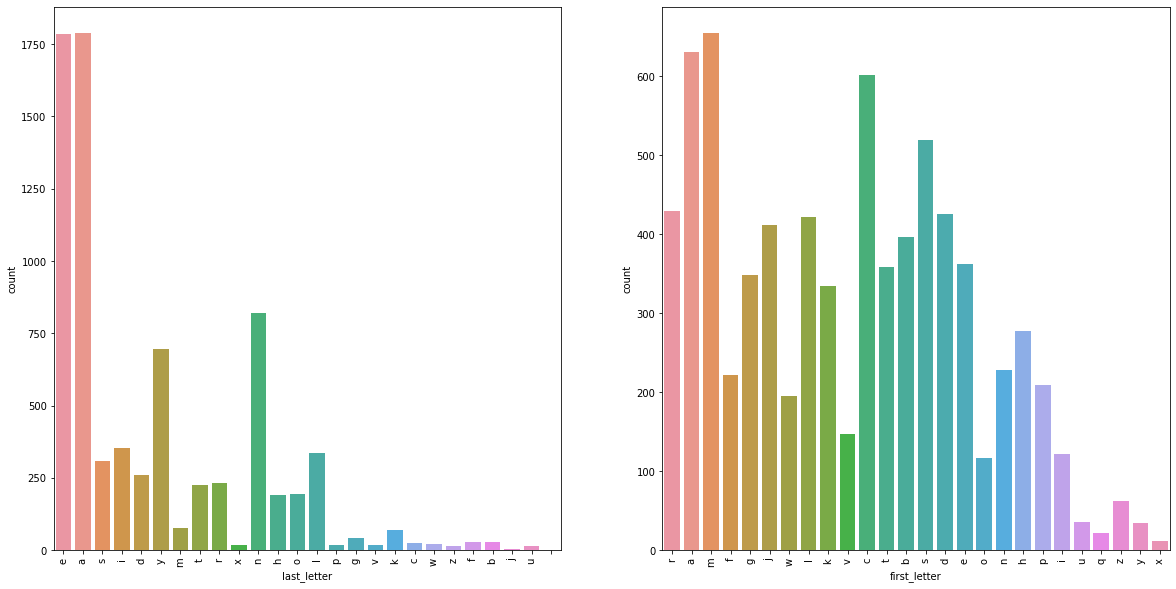

In [19]:
# categorical/numerical columns
categorical_cols = X.loc[:, [col for col in X.columns if 'gram' not in col]].select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for var, subplot in zip(categorical_cols[:2], ax.flatten()):
    sns.countplot(x=var, data=data, ax=subplot)
    # rotate labels for easy viewing
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

The distributions above don't tell us much. We need to condition on gender.

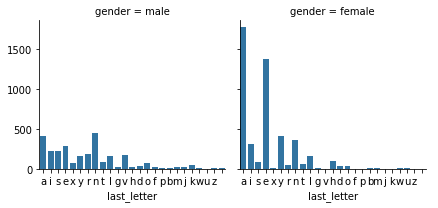

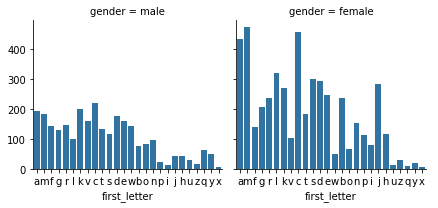

In [29]:
cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'last_letter').add_legend()
plt.tight_layout()
plt.show()

cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'first_letter').add_legend()
plt.tight_layout()
plt.show()

It would appear that both the first and the last letter could be pretty good predictors for gender.

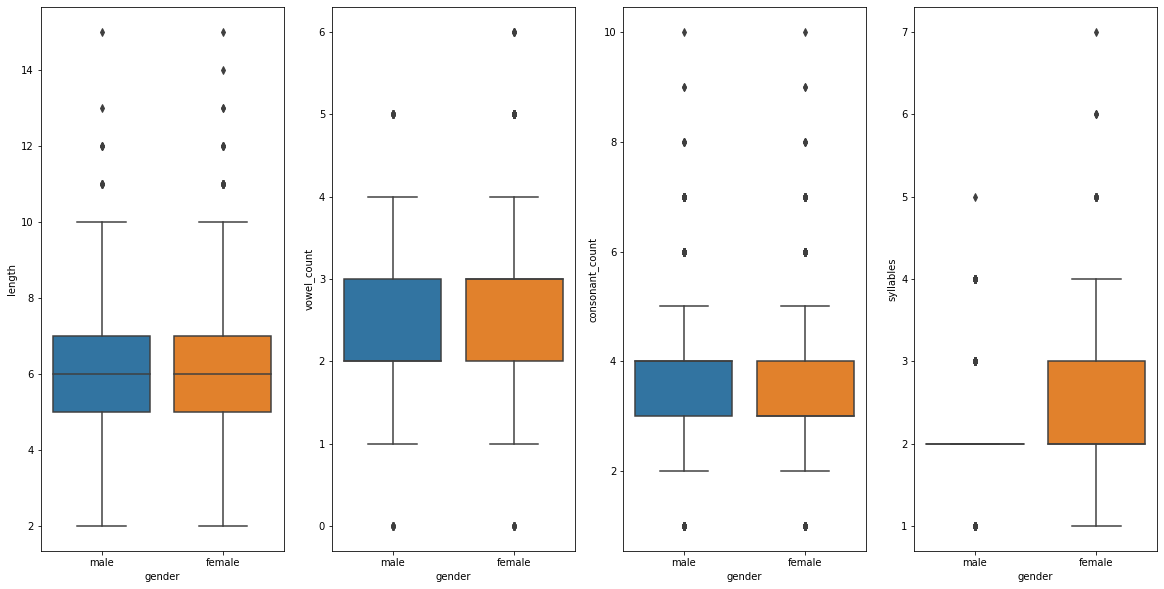

In [18]:
# numerical columns to gender exploration
fig, ax = plt.subplots(1, 4, figsize=(20, 10))

for var, subplot in zip(numerical_cols, ax.flatten()):
    sns.boxplot(x='gender', y=var, data=data, ax=subplot)
    

From the boxplots above, we can safely rule out vowel cunt, consonant count, and length as strong predictors of gender.

## Data Preparation
We need to apply our feature generation function to our list of names and then split the lists into training, test, and validation sets.

In [15]:
# apply feature generation function
all_names = [(gender_features(name), gender) for name, gender in all_names]

# create each set of data
train = all_names[:500]
dev_test = all_names[500:1000]
test = all_names[-6900:]
